# Image Attention Map for CLIP

### **Name: Mahdi Shafiei**
### **STD ID: 99109409**

For testing the appoaches of calculating image attention map, the image below has been chosen due to existance of many objects in it.

In [ ]:
!git clone https://github.com/hila-chefer/Transformer-MM-Explainability

import torch
import requests
import numpy as np
import torchvision
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import transforms
import torch.nn
import torch.autograd.functional as f
import torchvision.datasets as dset
import torchvision.transforms as transforms
from zipfile import ZipFile, BadZipFile
import os
import os
os.chdir(f'./Transformer-MM-Explainability')
!pip install einops
!pip install ftfy
!pip install captum
import CLIP.clip as clip
device = "cuda" if torch.cuda.is_available() else "cpu"

Cloning into 'Transformer-MM-Explainability'...
remote: Enumerating objects: 1477, done.
remote: Counting objects: 100% (104/104), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 1477 (delta 82), reused 69 (delta 60), pack-reused 1373
Receiving objects: 100% (1477/1477), 29.01 MiB | 19.62 MiB/s, done.
Resolving deltas: 100% (571/571), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.9 MB/s eta 0:00:00


## Loading CLIP Model

In [ ]:
print(device)
clip.clip._MODELS = {
    "ViT-B/32": "https://openaipublic.azureedge.net/clip/models/40d365715913c9da98579312b702a82c18be219cc2a73407c4526f58eba950af/ViT-B-32.pt"
}
model, preprocess = clip.load("ViT-B/32", device=device,  jit=False)

cuda


100%|███████████████████████████████████████| 354M/354M [00:07<00:00, 47.4MiB/s]


## Loading data

In [ ]:
!wget http://images.cocodataset.org/zips/val2017.zip -O coco_val2017.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip -O coco_ann2017.zip

def extract_zip_file(extract_path):
    try:
        with ZipFile(extract_path+".zip") as zfile:
            zfile.extractall(extract_path)
        zfileTOremove=f"{extract_path}"+".zip"
        if os.path.isfile(zfileTOremove):
            os.remove(zfileTOremove)
        else:
            print("Error: %s file not found" % zfileTOremove)
    except BadZipFile as e:
        print("Error:", e)
extract_val_path = "./coco_val2017"
extract_ann_path="./coco_ann2017"
extract_zip_file(extract_val_path)
extract_zip_file(extract_ann_path)

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_set = dset.CocoCaptions(root = '/content/Transformer-MM-Explainability/coco_val2017/val2017',
                        annFile = '/content/Transformer-MM-Explainability/coco_ann2017/annotations/captions_val2017.json',
                        transform=transforms.ToTensor())

--2023-07-12 21:46:11--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.177.75, 52.217.193.121, 54.231.204.161, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.177.75|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘coco_val2017.zip’

coco_val2017.zip    100%[===================>] 777.80M  33.5MB/s    in 24s     

2023-07-12 21:46:35 (32.6 MB/s) - ‘coco_val2017.zip’ saved [815585330/815585330]

--2023-07-12 21:46:35--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 3.5.7.21, 52.217.201.241, 52.217.225.129, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|3.5.7.21|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘coco_ann2017.zip’

coco_ann2017.zip    100%[

# Calculating CLIP Image Attention Map

To calculate attention map of an input image, we examine two different methods:
1. Using probabilities of CLIP's built-in Attention module.
2. Calculating similarity between smaller parts of input image and the whole image.

## 1. Indirect Method: Using probabilities of CLIP's built-in Attention module:

In order to understand which parts of the input image have the most effect on the performance of the model, we should calculate which parts of the image have the most effect on the similarity of encoding of input image and input text. So we can use Attention Probabilities of the last MultiHeadAttention module in CLIP architecture to calculate importance of each part of the input. <br>

The CLIP model has a $32*32$ conv layer with $32*32$ strides and each image becomes a $224*224$ image after preprocessing, therfore it devides the input into $49$ pathes which then several layers of multi-headed attention is performed on each patch. So by using attention probabilities of the last visual attention layer of CLIP (which is implemented in the function `img_attention()`), we can understand how each of those 49 parts contribute to the output of CLIP. <br>

But we know that attention map of image is also depends on the given text prompt, so we combine another measurement, which is understanding that how each patch effects the similarity of image encoding vector with the prompt text encoding vector. To calculate this effect, we calculate the gradient of encoding similarities w.r.t the attention probalities.<br>

To combine these two factors, we multiply these two values with eachother, which tells us how each patch is important and how this importance fluctuates the output similarity at the same time.


In [ ]:
def img_attention(image, texts, model, device, start_layer=-1, start_layer_text=-1):
    logits = torch.matmul(model.encode_image(image), model.encode_text(texts).T).sum()
    model.zero_grad()
    image_attn_blocks = list(dict(model.visual.transformer.resblocks.named_children()).values())
    blk = image_attn_blocks[-1]
    grad = torch.autograd.grad(logits, [blk.attn_probs], retain_graph=True)[0].detach()
    prob = blk.attn_probs.detach()
    prob = grad * prob
    prob = prob.reshape(12, prob.shape[-1], prob.shape[-1])
    prob = prob.clamp(min=0).mean(dim=0)
    R = prob * 1000
    image_relevance = R[0, 1:]
    return image_relevance

In [ ]:
import cv2
import warnings

def show_image_relevance(image_relevance, image, orig_image):
    def show_cam_on_image(img, mask):
        heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
        heatmap = np.float32(heatmap) / 255
        cam = heatmap + np.float32(img)
        cam = cam / np.max(cam)
        return cam
    fig, axs = plt.subplots(1, 2)
    warnings.filterwarnings('ignore')
    axs[0].imshow(orig_image);
    axs[0].axis('off');
    dim = int(image_relevance.numel() ** 0.5)
    image_relevance = image_relevance.reshape(1, 1, dim, dim)
    image_relevance = torch.nn.functional.interpolate(image_relevance, size=224, mode='bilinear')
    image_relevance = image_relevance.reshape(224, 224).data.cpu().numpy()
    image_relevance = (image_relevance - image_relevance.min()) / (image_relevance.max() - image_relevance.min())
    image = image[0].permute(1, 2, 0).data.cpu().numpy()
    image = (image - image.min()) / (image.max() - image.min())
    vis = show_cam_on_image(image, image_relevance)
    vis = np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    axs[1].imshow(vis.astype('uint8'));
    axs[1].axis('off');


In [ ]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

Prompt: a man smiling


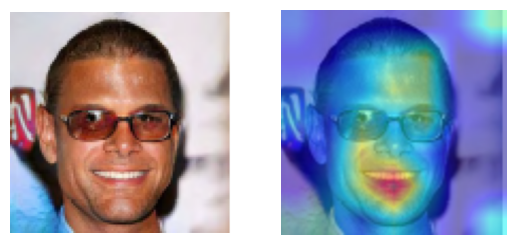


Prompt: a man wearing eyeglasses


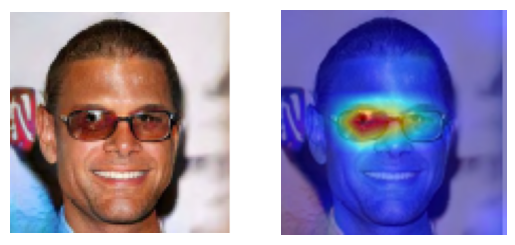

In [ ]:
img_path = "CLIP/glasses.png"
img = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
text = "a man smiling"
text_token = clip.tokenize(text).to(device)
R_image = img_attention(model=model, image=img, texts=text_token, device=device)
show_image_relevance(R_image, img, orig_image=Image.open(img_path))
print(f'Prompt: {text}')
plt.show()
print()

img = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
text = "a man wearing eyeglasses"
text_token = clip.tokenize(text).to(device)
R_image = img_attention(model=model, image=img, texts=text_token, device=device)
show_image_relevance(R_image, img, orig_image=Image.open(img_path))
print(f'Prompt: {text}')
plt.show()

Prompt: cat


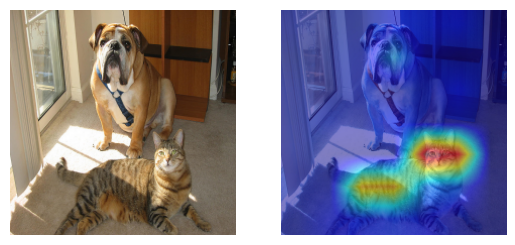


Prompt: a dog


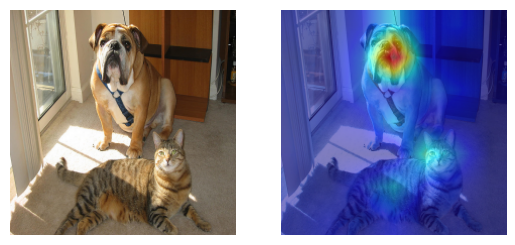

In [ ]:
img_path = "CLIP/catdog.png"
img = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
text = "cat"
text_token = clip.tokenize(text).to(device)
R_image = img_attention(model=model, image=img, texts=text_token, device=device)
show_image_relevance(R_image, img, orig_image=Image.open(img_path))
print(f'Prompt: {text}')
plt.show()
print()

img = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
text = "a dog"
text_token = clip.tokenize(text).to(device)
R_image = img_attention(model=model, image=img, texts=text_token, device=device)
show_image_relevance(R_image, img, orig_image=Image.open(img_path))
print(f'Prompt: {text}')
plt.show()

Prompt: a dog


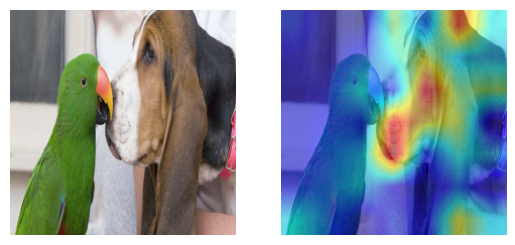


Prompt: a parrot


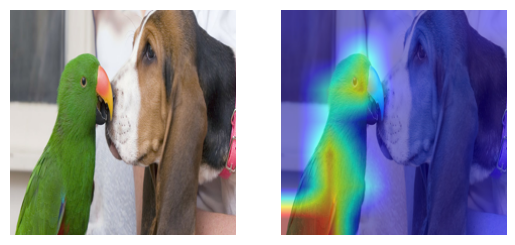

<PIL.PngImagePlugin.PngImageFile image mode=RGB size=224x224 at 0x7F20DD68EDA0>


In [ ]:
img_path = "CLIP/dogbird.png"
img = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
text = "a dog"
text_token = clip.tokenize(text).to(device)
R_image = img_attention(model=model, image=img, texts=text_token, device=device)
show_image_relevance(R_image, img, orig_image=Image.open(img_path))
print(f'Prompt: {text}')
plt.show()
print()

img = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
text = "a parrot"
text_token = clip.tokenize(text).to(device)
R_image = img_attention(model=model, image=img, texts=text_token, device=device)
show_image_relevance(R_image, img, orig_image=Image.open(img_path))
print(f'Prompt: {text}')
plt.show()
print(Image.open(img_path))

Prompt: a black cat


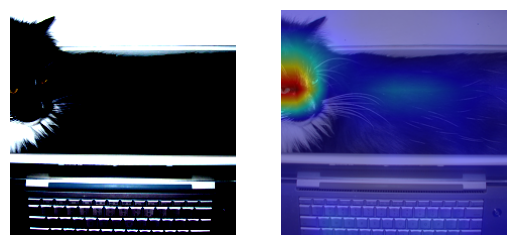

Prompt: a keyboard


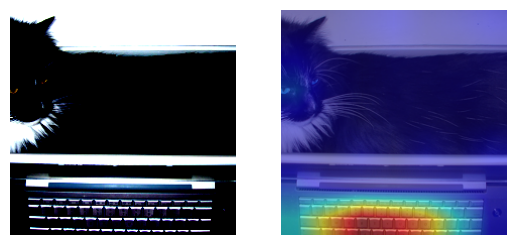

In [ ]:
img, text = train_set[18]
img = preprocess(torchvision.transforms.functional.to_pil_image(img)).unsqueeze(0).to(device)
text = 'a black cat'
text_token = clip.tokenize(text).to(device)
R_image = img_attention(model=model, image=img, texts=text_token, device=device)
show_image_relevance(R_image, img, img[0].permute(1, 2, 0).data.cpu().numpy())
print(f'Prompt: {text}')
plt.show()
print()

img, text = train_set[18]
img = preprocess(torchvision.transforms.functional.to_pil_image(img)).unsqueeze(0).to(device)
text = 'a keyboard'
text_token = clip.tokenize(text).to(device)
R_image = img_attention(model=model, image=img, texts=text_token, device=device)
show_image_relevance(R_image, img, img[0].permute(1, 2, 0).data.cpu().numpy())
print(f'Prompt: {text}')
plt.show()
print()

As we can see, CLIP Attention mechansim and our approach to detect it work very well for images with small number of objects in them. But when we increase the number of objects in the image or the number of words in the prompt, Attention fails to perform well:

Prompt: a keyboard


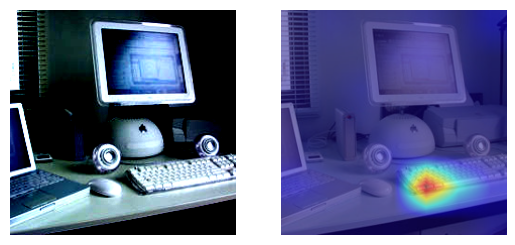

Prompt: A computer on a desk next to a laptop.


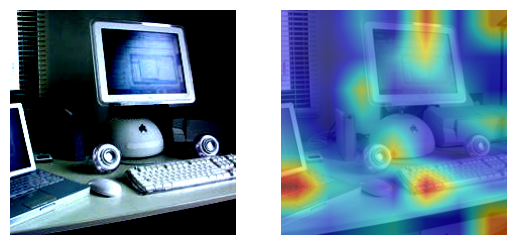

In [ ]:
img, text = train_set[15]
img = preprocess(torchvision.transforms.functional.to_pil_image(img)).unsqueeze(0).to(device)
text = 'a keyboard'
text_token = clip.tokenize(text).to(device)
R_image = img_attention(model=model, image=img, texts=text_token, device=device)
show_image_relevance(R_image, img, img[0].permute(1, 2, 0).data.cpu().numpy())
print(f'Prompt: {text}')
plt.show()
print()

_, text = train_set[15]
text = text[0]
text_token = clip.tokenize(text).to(device)
R_image = img_attention(model=model, image=img, texts=text_token, device=device)
show_image_relevance(R_image, img, img[0].permute(1, 2, 0).data.cpu().numpy())
print(f'Prompt: {text}')
plt.show()
print()

Prompt: cars on the road


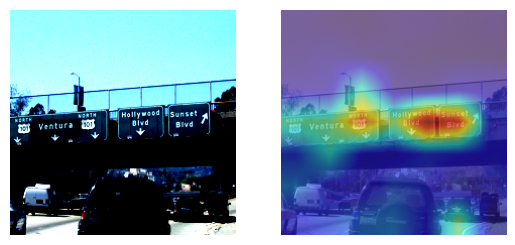

In [ ]:
img, text = train_set[16]
img = preprocess(torchvision.transforms.functional.to_pil_image(img)).unsqueeze(0).to(device)
text = 'cars on the road'
text_token = clip.tokenize(text).to(device)
R_image = img_attention(model=model, image=img, texts=text_token, device=device)
show_image_relevance(R_image, img, img[0].permute(1, 2, 0).data.cpu().numpy())
print(f'Prompt: {text}')
plt.show()
print()

Prompt: a table with knife and raspberry and cake


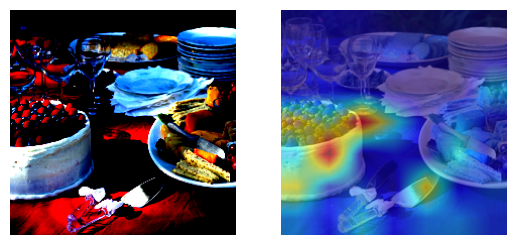

In [ ]:
img, text = train_set[25]
img = preprocess(torchvision.transforms.functional.to_pil_image(img)).unsqueeze(0).to(device)
text = 'a table with knife and raspberry and cake'
text_token = clip.tokenize(text).to(device)
R_image = img_attention(model=model, image=img, texts=text_token, device=device)
show_image_relevance(R_image, img, img[0].permute(1, 2, 0).data.cpu().numpy())
print(f'Prompt: {text}')
plt.show()
print()

## 2. Calculating similarity between smaller parts of input image and the whole image

In this approach, we don't take input text into account, and only examine simillarity between each part of the input image and the whole image. To to this, we divide the input image into 49 smaller patches, and calculate CLIP encoding representation of each of those patches. Then, we calculate the similarity between the representation of each patch and the complete image, in this way we can understand representation of which parts of the input image is similar to the representation of the whole image. Ideally, we want the representation of an image be close to the representation of important objects in it.

In [ ]:
!pip install git+https://github.com/openai/CLIP.git
import clip
model, preprocess = clip.load("ViT-B/32", device=device)

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-k0kip71o
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-k0kip71o
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369501 sha256=1f9ae4f3335a4e171628796950ec545f0430bbcaec7e349fb6838f2293b9d8e3
  Stored in directory: /tmp/pip-ephem-wheel-cache-87lqlw_p/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [ ]:
def divide_image(img):
    cropped = torch.zeros((49, 3, 32, 32))
    for i in range(7):
        for j in range(7):
            cropped_image = img[:, :, i*32:i*32+32, j*32:j*32+32]
            cropped[7*i + j] = cropped_image
            del cropped_image
    cropped = transforms.functional.resize(cropped, size=(224, 224))
    return cropped

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([49, 3, 224, 224])


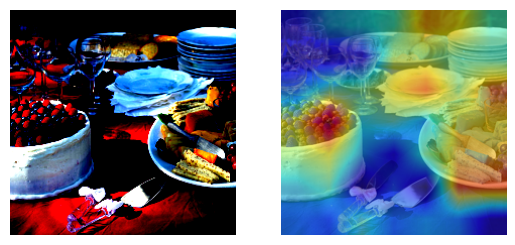

In [ ]:
img, text = train_set[25]
img = preprocess(torchvision.transforms.functional.to_pil_image(img)).unsqueeze(0).to(device)
cropped = divide_image(img)
print(cropped.shape)

model.eval()
with torch.no_grad():
    image_features = model.encode_image(cropped)
    full_features = model.encode_image(img).T
    similarity = torch.matmul(image_features, full_features)
    show_image_relevance(similarity.view(49), img, img[0].permute(1, 2, 0).data.cpu().numpy())
del image_features, cropped, img, similarity, full_features

For example in the image above, representation of the image is closer to the red and orange parts including the *raspberry* and *cake* rather than the blue parts including *drink glasses* and the *knife*, therefore *raspberry* and *cake* prompts have more chance to match the image rather than *drink glasses*  and  *knife*.

torch.Size([49, 3, 224, 224])


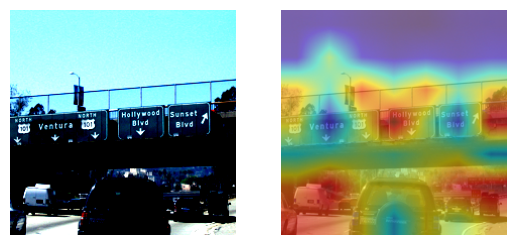

In [ ]:
img, text = train_set[15]
img = preprocess(torchvision.transforms.functional.to_pil_image(img)).unsqueeze(0).to(device)
cropped = divide_image(img)
print(cropped.shape)

model.eval()
with torch.no_grad():
    image_features = model.encode_image(cropped)
    full_features = model.encode_image(img).T
    similarity = torch.matmul(image_features, full_features)
    show_image_relevance(similarity.view(49), img, img[0].permute(1, 2, 0).data.cpu().numpy())
del image_features, cropped, img, similarity, full_features

torch.Size([49, 3, 224, 224])


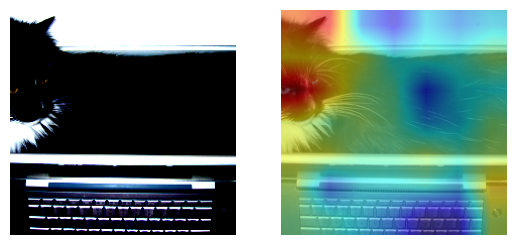

In [ ]:
img, text = train_set[18]
img = preprocess(torchvision.transforms.functional.to_pil_image(img)).unsqueeze(0).to(device)
cropped = divide_image(img)
print(cropped.shape)

model.eval()
with torch.no_grad():
    image_features = model.encode_image(cropped)
    full_features = model.encode_image(img).T
    similarity = torch.matmul(image_features, full_features)
    show_image_relevance(similarity.view(49), img, img[0].permute(1, 2, 0).data.cpu().numpy())
del image_features, cropped, img, similarity, full_features

We can see that this approach too is kind of succesfull and is able to explain the attention map for simpler images. But as we can see below similar to the first approach, the attention map is not fully concentrated on the important parts of the more complex images, therefore leading us to believe that CLIP's attention system is not perfect.

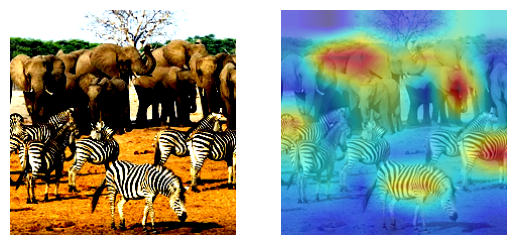

In [ ]:
img_path = "CLIP/el4.png"
img = Image.open(img_path)
convert_tensor = transforms.ToTensor()
img = convert_tensor(img)
with torch.no_grad():
    img = preprocess(torchvision.transforms.functional.to_pil_image(img)).unsqueeze(0).to(device)
cropped = divide_image(img)

model.eval()
with torch.no_grad():
    image_features = model.encode_image(cropped)
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)
    full_features = model.encode_image(img)
    full_features = full_features / full_features.norm(dim=-1, keepdim=True)
    similarity = torch.matmul(image_features, full_features.T)
    show_image_relevance(similarity.view(49), img, img[0].permute(1, 2, 0).data.cpu().numpy())
del image_features, cropped, img, similarity, full_features

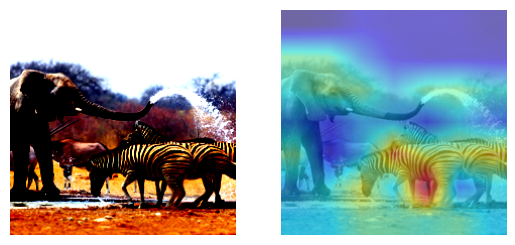

In [ ]:
img_path = "CLIP/el3.png"
img = Image.open(img_path)
convert_tensor = transforms.ToTensor()
img = convert_tensor(img)
with torch.no_grad():
    img = preprocess(torchvision.transforms.functional.to_pil_image(img)).unsqueeze(0).to(device)
cropped = divide_image(img)

model.eval()
with torch.no_grad():
    image_features = model.encode_image(cropped)
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)
    full_features = model.encode_image(img)
    full_features = full_features / full_features.norm(dim=-1, keepdim=True)
    similarity = torch.matmul(image_features, full_features.T)
    show_image_relevance(similarity.view(49), img, img[0].permute(1, 2, 0).data.cpu().numpy())
del image_features, cropped, img, similarity, full_features

# Fine Tuning CLIP TO Improve Attention Performance



In order to solve the problem of inaccurate image attention patterns, we have to somehow give information about smaller patches of image and words of input text to our model, so that we could benefit from good performance of our model on small patches and less complex images without actually dividing our input image into smaller parts during evaluation and test. <br>


Our goal is to make the encoding of each image as close as possible to the encoding of the **important parts** of the image (which should be equivalent to the encoding of the important words of the equivalent image caption), so that each text that matches with those important parts also would be matched with the whole image itself. We know that the current CLIP model is not great at doing this task, so we have to modify the model to achieve this goal. We hypothesise that this problem can be solved or at least reduced by changing the encoding system of the CLIP model, so we add another Fully Connected model called `TuneHead` to the end of each encoding module of the CLIP model: one to the `model.encode_image` and one to the `model.encode_text` module. Then, we use the approach and contrastive loss that will shortly be explained to train these two models. I believe that this approach is by far more effective and less computationally expensive than changing weights of the original CLIP model itself, because it directly attacks the encoding of the model, and doesn't require the flow of gradient through the huge model of CLIP.<br>


Since now, each encoding of image and text will be done using the added heads. First, using dataloader, we divide each training image into 16 square patches and remove stopwords from training texts and split each text into words and tokenize them (maximum number of words for each text has been set to 15 to normalize our text data). Therefore, $i$th image data of a training batch consists of a complete image $Image^{i}$ and $16$ $Patch_{m}^{i}$, and $j$th text data of each batch consists of tokens of the entire caption $Text^{j}$ and 15 tokens of words $Word_n^j$.<br>

Then, the related encoding will be performed on each of the data above, and each will be represented by a $x \in R^{512}$ vector which is represented below:
$$
I^{i} = Enc_{\theta}(Image^{i})
$$

$$
P_{m}^{i} = Enc_{\theta}(Patch_{m}^{i})
$$

$$
T^{j} = Enc_{\psi}(Text^{j})
$$

$$
W_{n}^{j} = Enc_{\psi}(Word_n^j)
$$

which $Enc_{\theta}$ is the image encoding model and $Enc_{\psi}$ is the text encoding model (including the fine-tuning heads). <br>

In order to find out the encoding of important parts of each training data, we define the similarity between $Image^{i}$ and $Text^{j}$ as below:
$$
similarity(Image^{i}, Text^{j}) = (I^{i})^⊤ (W_{q}^{j})
$$

$$
similarity(Text^{j}, Image^{i}) = (T^{j})^⊤ (P_{p}^{j})
$$


which $p$ and $q$ are equal to:

$$
p, q = arg\max_{m, n}((P_{m}^{i})^⊤ (W_{n}^{j}))
$$

But how do we know $P_{p}^{j}$ and $W_{q}^{j}$ are important? Because $P_{p}^{j}$ and $W_{q}^{j}$ have matched with eachother very well, therefore $P_{p}^{j}$ was not only important enough to be a part of the image caption, but important enough to be depicted perfectly in $Image^{i}$ so that it could match its equivalend word well.

Then, Cross Entropy loss will be performed on these two similarities to ensure that $Image^{i}$ is most similar to $Text^{i}$ and vice-versa. By using this loss function, we ensure that representation of $Image^{i}$ is as close as possible to the most important word of $Text^{i}$. But earlier we saw that the representation of the most important word of $Text^{i}$ is close to the representation of the most important patch in $Image^{i}$, therefore we can be certain that the representation of $Image^{i}$ is close to the representation of the most important patch in $Image^{i}$, and attention patern of the modified CLIP will be improved after training.

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Function to divide image into n patches

def divide_image(img, dim):
    num = int(224/dim)
    cropped = torch.zeros((num*num, 3, dim, dim)).to(device)
    for i in range(num):
        for j in range(num):
            cropped_image = img[:, :, i*dim:i*dim+dim, j*dim:j*dim+dim].to(device)
            cropped[num*i + j] = cropped_image
            del cropped_image
    cropped = transforms.functional.resize(cropped, size=(224, 224))
    return cropped

# Import OpenAI CLIP model

!pip install git+https://github.com/openai/CLIP.git
import clip
model, preprocess = clip.load("ViT-B/32", device=device)

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-p3lr6qv3
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-p3lr6qv3
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369501 sha256=64301f1e8d2a9e457d498226f2c435fa79a9b941f3ea45c5bf597336e82b181d
  Stored in directory: /tmp/pip-ephem-wheel-cache-kfudnmo_/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


## Preparing Data

In [ ]:
import gensim.parsing.preprocessing as gensim

# Prepare Dataset
class Dataset(torch.utils.data.Dataset):
  def __init__(self, data):
        self.data = data

  def __len__(self):
        return len(self.data)

  def __getitem__(self, index):
        img, text = self.data[index]
        text = text[0]
        text = gensim.remove_stopwords(text.lower())
        img = preprocess(torchvision.transforms.functional.to_pil_image(img)).unsqueeze(0).to(device)
        dim = 56
        num = int(224/dim)
        cropped = divide_image(img, dim).reshape(num*num, 3, 224, 224)
        y = clip.tokenize(text).to(device).reshape(77)
        ys = text.split()
        if len(ys) > 15:
            ys = ys[:15]
            ys = clip.tokenize(ys).to(device)
        else:
            while len(ys) < 15:
                ys.append('')
            ys = clip.tokenize(ys).to(device)
        return img.reshape(3, 224, 224), cropped, y, ys, text

In [ ]:
!wget http://images.cocodataset.org/zips/train2017.zip -O coco_train2017.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip -O coco_ann2017.zip

def extract_zip_file(extract_path):
    try:
        with ZipFile(extract_path+".zip") as zfile:
            zfile.extractall(extract_path)
        zfileTOremove=f"{extract_path}"+".zip"
        if os.path.isfile(zfileTOremove):
            os.remove(zfileTOremove)
        else:
            print("Error: %s file not found" % zfileTOremove)
    except BadZipFile as e:
        print("Error:", e)

extract_val_path = "./coco_train2017"
extract_ann_path="./coco_ann2017"
extract_zip_file(extract_val_path)
extract_zip_file(extract_ann_path)

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_set = dset.CocoCaptions(root = '/content/Transformer-MM-Explainability/coco_train2017/train2017',
                        annFile = '/content/Transformer-MM-Explainability/coco_ann2017/annotations/captions_train2017.json',
                        transform=transforms.ToTensor())

dataset = Dataset(train_set)
train_set = train_set[:40000]
trainloader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)

## Define the Fine Tune Model

Here we define our `TuneHead` model which consists of 5 layers of fully connected layers with the maximum number of neurons of 4092 and ReLU activation functions and Batch Normalization. We use a residual forward method because we want just want to correct our original model, and by using a residual connection, we can use the original state of CLIP as a starting point and accelerate our training.

In [ ]:
import torch.nn as nn

class TuneHead(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(512, 1024, dtype=torch.float32),
            nn.ReLU(),
            nn.Linear(1024, 2048, dtype=torch.float32),
            nn.BatchNorm1d(2048, affine=False),
            nn.ReLU(),
            nn.Linear(2048, 4092, dtype=torch.float32),
            nn.BatchNorm1d(4092, affine=False),
            nn.ReLU(),
            nn.Linear(4092, 2048, dtype=torch.float32),
            nn.BatchNorm1d(2048, affine=False),
            nn.ReLU(),
            nn.Linear(2048, 512, dtype=torch.float32)
        )

    def forward(self, x):
        return self.layers(x)

## Training

Our training loop has 5 epochs (which we will see later that it is enough) and Cross Entropy loss and Adam with learning rate of `1e-6` and beta values of `0.9, 0.98` have been used (parameters of both fine-tune heads will be updated at the same time). Eventhough backpropagation is performed on the newly introduced loss function and not the traditional loss function, but the traditional loss function is also calculated and recorded to observe the performance of fine-tune heads, but they won't be used to train the model.

In [ ]:
from tqdm import tqdm
import torch.optim

# Create Fine-tune Heads
image_head = TuneHead().to(device)
text_head = TuneHead().to(device)

# CLIP model
model.to(device)

loss_img = nn.CrossEntropyLoss()
loss_txt = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(list(image_head.parameters()) + list(text_head.parameters()), lr=1e-6, betas=(0.9, 0.98), eps=1e-6, weight_decay=0.2)
counter = 0

contrastive_losses = []
original_losses = []

In [ ]:
contrastive_losses = []
original_losses = []
train_accs = []
for m in range(1):
    with tqdm(trainloader, unit="batch") as tepoch:
        for img, cropped, text, word, kalame in tepoch:
            image_head.train()
            tepoch.set_description(f"Epoch {m+1}")
            img = img.to(device)
            cropped = cropped.to(device)
            text = text.to(device)
            word = word.to(device)

            # Get batch size, number of image patches and number of words
            bs, num = cropped.shape[0], cropped.shape[1]
            bs, tok = word.shape[0], word.shape[1]

            # Encode data using original CLIP model
            model.eval()
            with torch.no_grad():
                img_features = model.encode_image(img)
                cropped_features = model.encode_image(cropped.reshape(bs*num, 3, 224, 224))
                text_features = model.encode_text(text)
                word_features = model.encode_text(word.reshape(bs*tok, 77))

            # Encode the output of CLIP by our fine-tuning heads
            img_features = img_features.to(torch.float32)
            text_features = text_features.to(torch.float32)
            cropped_features = cropped_features.to(torch.float32)
            word_features = word_features.to(torch.float32)

            img_features = image_head(img_features)
            text_features = text_head(text_features)
            cropped_features = image_head(cropped_features)
            word_features = text_head(word_features)

            cropped_features = cropped_features.reshape(bs, num, 512)
            word_features = word_features.reshape(bs, tok, 512)

            # Normalize feature vectors
            img_features = img_features / img_features.norm(dim=-1, keepdim=True)
            text_features = text_features / text_features.norm(dim=-1, keepdim=True)
            cropped_features = cropped_features / cropped_features.norm(dim=-1, keepdim=True)
            word_features = word_features / word_features.norm(dim=-1, keepdim=True)

            # Calculate the two similarity matrices
            image_similarity = torch.zeros(bs, bs, device=device)
            text_similarity = torch.zeros(bs, bs, device=device)
            for i in range(bs):
                for j in range(bs):
                    # Get patches and words
                    pathes = cropped_features[i]
                    words = word_features[j]

                    # Calculate similarity between all pairs of patches and words
                    att = torch.matmul(pathes, words.T)

                    # Calculate indices of most important patch and word
                    arg = torch.argmax(att)
                    max_patch = int(arg // num)
                    max_word = int(arg % tok)

                    # Calculate similarity between image and most important word
                    x1 = img_features[i]
                    x2 = word_features[j, max_word]
                    image_similarity[i, j] = torch.matmul(x1.T, x2)

                    # Calculate similarity between caption and most important patch
                    x2 = cropped_features[i, max_patch]
                    x1 = text_features[j]
                    text_similarity[j, i] = torch.matmul(x1.T, x2)

            # Calculate Cross Entropy loss for image_similarity and text_similarity
            ground_truth = torch.eye(bs, dtype=torch.float16,device=device)
            loss1 = loss_img(image_similarity, ground_truth)
            loss2 = loss_txt(text_similarity, ground_truth)
            loss_new = (loss1+loss2) / 2

            # Perform backpropagation and record contrastive losse
            my_loss = loss.item()
            contrastive_losses.append(my_loss)

            # Calculate and record traditional loss
            att = torch.matmul(img_features, text_features.T)
            optimizer.step()
            loss1 = loss_img(att, ground_truth)
            loss2 = loss_txt(att.T, ground_truth)
            loss_old = (loss1+loss2) / 2
            loss = (loss_new+loss_old)/2
            loss.backward()
            original_loss = ((loss1+loss2)/2).item()
            original_losses.append(original_loss)

            predictions = torch.argmax(att, dim=1)
            ground_truth = torch.arange(bs, device=device)
            acc = torch.sum(ground_truth == predictions)/bs
            train_accs.append(acc.item())

            tepoch.set_postfix(contrastive_loss=my_loss, original_loss=original_loss, acc=acc.item())



Epoch 5: 100%|██████████| 313/313 [05:37<00:00,  1.08s/batch, acc=0.75, contrastive_loss=2.09, original_loss=1.31]


## Results

The moving average of Actual Loss (traditional loss) and Contrastive Loss (newly introduced loss function) have been shown below.

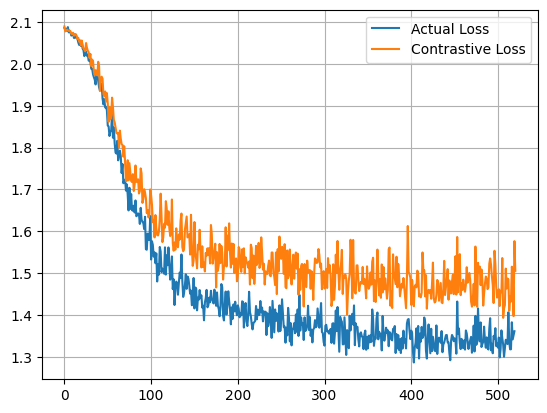

In [ ]:
n=6
original_losses_avg = [sum(original_losses[i:i+n])/n for i in range(0, len(original_losses), n)][:-1]
contrastive_losses_avg = [sum(contrastive_losses[i:i+n])/n for i in range(0, len(contrastive_losses), n)][:-1]
train_acc_avg = [sum(train_accs[i:i+n])/n for i in range(0, len(train_accs), n)][:-1]

plt.plot(range(len(original_losses_avg)), original_losses_avg, label='Actual Loss')
plt.plot(range(len(contrastive_losses_avg)), contrastive_losses_avg, label='Contrastive Loss')
plt.grid()
plt.legend()
plt.show()

As we can see, Contrastive Loss has decreased substantially as expected (because backpropagation has been performed on this loss) and both Contrastive Loss and Original Loss have converged, which tells us larger datasets and epoch steps would not help us that much.

In [ ]:
# saving fine tuning models
from google.colab import drive
drive.mount('/content/drive')
torch.save(image_head.state_dict(), '/content/drive/My Drive/image_head.pth')
torch.save(text_head.state_dict(), '/content/drive/My Drive/text_head.pth')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load ine tuning models
test_image = TuneHead()
test_image.load_state_dict(torch.load('/content/drive/My Drive/image_head.pth'))
test_image = test_image.to(device)

test_text = TuneHead()
test_text.load_state_dict(torch.load('/content/drive/My Drive/text_head.pth'))
test_text = test_text.to(device)

The function below uses the second approch that we introduced in the prevoius section to calculate attention map for an image. Note that dividing image into patches has been implemented just to calculate attention map and serves no other perpose, and such operation does not take place during a image-text matching task.

In [ ]:
def eval_attn(img, model, test_image):
    with torch.no_grad():
        # Preprocess img
        img = preprocess(torchvision.transforms.functional.to_pil_image(img)).unsqueeze(0).to(device)

    # Crop image into n*n smaller patches
    cropped = divide_image(img, 32).reshape(49, 3, 224, 224)

    model.eval()
    with torch.no_grad():
        # Calculate encoding of the original image
        image_features = model.encode_image(cropped)
        image_features = test_image(image_features)

        # Normalize
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)

        # Calculate encoding of the patches
        full_features = model.encode_image(img)
        full_features = test_image(full_features)

        # Normalize
        full_features = full_features / full_features.norm(dim=-1, keepdim=True)

        # Calcuate similarity between image and each patch of it
        similarity = torch.matmul(image_features, full_features.T)
        similarity = (similarity + 1)/2
        similarity = similarity.log()

        # Show attention map
        show_image_relevance(similarity.view(49).to(torch.float64).cpu(), img, img[0].permute(1, 2, 0).data.cpu().numpy())
        warnings.filterwarnings('ignore')
        plt.show()
    del image_features, cropped, img, similarity, full_features

## Evaluation of Image Attention Map

First we evaluate attention map of our new model on training images. As we can see, our model works perfectly on simple images, and performs exeptionally better than the original CLIP model on complex images.

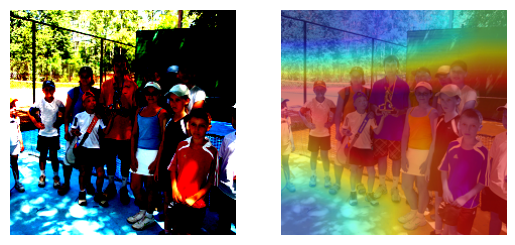

In [ ]:
img, text = train_set[9]
eval_attn(img, model, test_image)

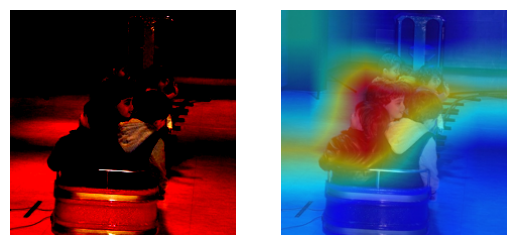

In [ ]:
img, text = train_set[12]
eval_attn(img, model, test_image)

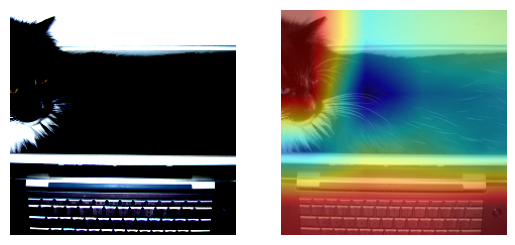

In [ ]:
img, text = train_set[18]
eval_attn(img, model, test_image)

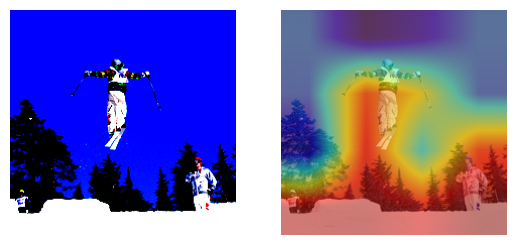

In [ ]:
img, text = train_set[29]
eval_attn(img, model, test_image)

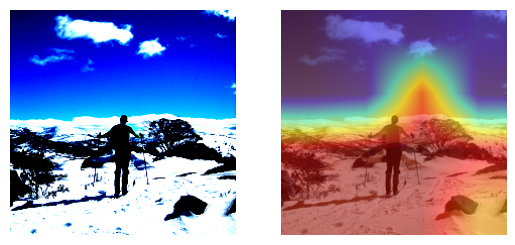

In [ ]:
img, text = train_set[30]
eval_attn(img, model, test_image)

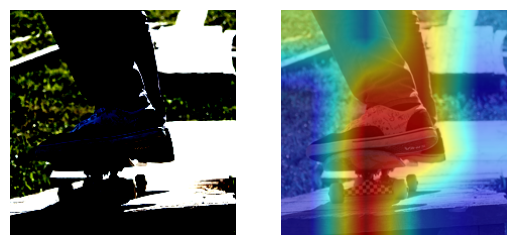

In [ ]:
img, text = train_set[38]
eval_attn(img, model, test_image)

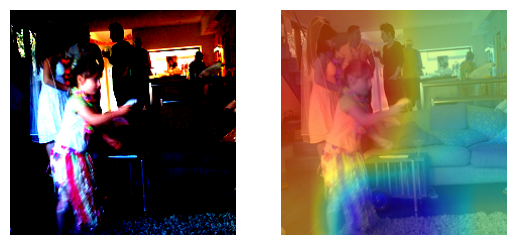

In [ ]:
img, text = train_set[41]
eval_attn(img, model, test_image)

## Evaluation on Test Set

Eventhough images below have not been used to train our model, but their attention maps are expetionally precise and matches the important parts of the original very well. There are some images that are common with the images used in the previous section, and we can see that our model works better, especially on more complicated images.

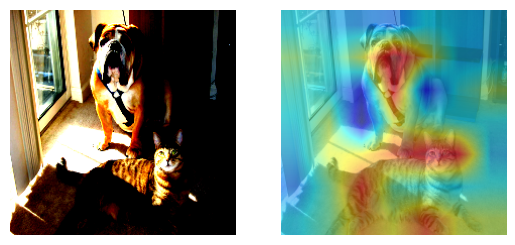

In [ ]:
img_path = "CLIP/catdog.png"
img = Image.open(img_path)
convert_tensor = transforms.ToTensor()
img = convert_tensor(img)
eval_attn(img, model, test_image)

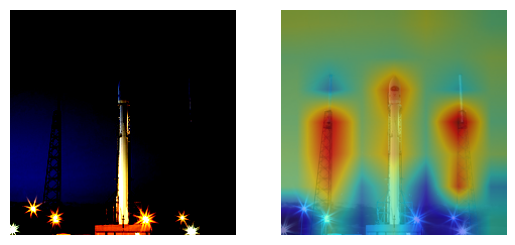

In [ ]:
img_path = "CLIP/rocket.jpg"
img = Image.open(img_path)
convert_tensor = transforms.ToTensor()
img = convert_tensor(img)
eval_attn(img, model, test_image)

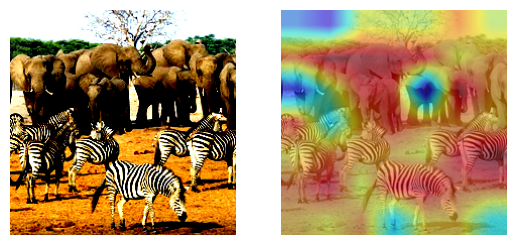

In [ ]:
img_path = "CLIP/el4.png"
img = Image.open(img_path)
convert_tensor = transforms.ToTensor()
img = convert_tensor(img)
eval_attn(img, model, test_image)

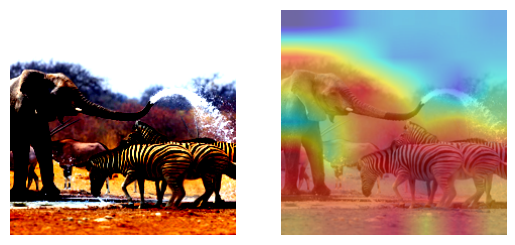

In [ ]:
img_path = "CLIP/el3.png"
img = Image.open(img_path)
convert_tensor = transforms.ToTensor()
img = convert_tensor(img)
eval_attn(img, model, test_image)

For example in the image above, we have shown in the second part of the previous section that the CLIP model did not pay attention to the elephant, but our fine-tuned model has fixed this problem, therefore if a prompt has either one of the animals in it, it will be matched with this image.

# Testing Accuracy

In [ ]:
!wget http://images.cocodataset.org/zips/train2017.zip -O coco_train2017.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip -O coco_ann2017.zip

--2023-07-12 23:20:24--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 3.5.28.226, 52.216.115.19, 52.217.71.228, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|3.5.28.226|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘coco_train2017.zip’

coco_train2017.zip  100%[===================>]  18.01G  57.2MB/s    in 4m 52s  

2023-07-12 23:25:16 (63.1 MB/s) - ‘coco_train2017.zip’ saved [19336861798/19336861798]

--2023-07-12 23:25:17--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 54.231.235.97, 52.217.38.164, 3.5.28.108, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|54.231.235.97|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘coco_ann2017.zip’

coco_ann2017.zip 

In [ ]:
!wget http://images.cocodataset.org/zips/train2017.zip -O coco_train2017.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip -O coco_ann2017.zip

def extract_zip_file(extract_path):
    try:
        with ZipFile(extract_path+".zip") as zfile:
            zfile.extractall(extract_path)
        zfileTOremove=f"{extract_path}"+".zip"
        if os.path.isfile(zfileTOremove):
            os.remove(zfileTOremove)
        else:
            print("Error: %s file not found" % zfileTOremove)
    except BadZipFile as e:
        print("Error:", e)
extract_val_path = "./coco_train2017"
extract_ann_path="./coco_ann2017"
extract_zip_file(extract_val_path)
extract_zip_file(extract_ann_path)

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_set = dset.CocoCaptions(root = '/content/Transformer-MM-Explainability/coco_train2017/train2017',
                        annFile = '/content/Transformer-MM-Explainability/coco_ann2017/annotations/captions_train2017.json',
                        transform=transforms.ToTensor())

In [ ]:
train_set = dset.CocoCaptions(root = '/content/Transformer-MM-Explainability/coco_train2017/train2017',
                        annFile = '/content/Transformer-MM-Explainability/coco_ann2017/annotations/captions_train2017.json',
                        transform=transforms.ToTensor())

!pip install git+https://github.com/openai/CLIP.git
import clip
model, preprocess = clip.load("ViT-B/32", device=device)

loading annotations into memory...
Done (t=1.15s)
creating index...
index created!
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-wr33lre6
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-wr33lre6
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369501 sha256=b1e7ecd37dae4bba536b3a83a725145095bb926312afddf8b7c0cc57ca394e17
  Stored in directory: /tmp/pip-ephem-wheel-cache-sbmf34rk/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


100%|████████████████████████████████████████| 338M/338M [00:03<00:00, 109MiB/s]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

test_image = TuneHead()
test_image.load_state_dict(torch.load('/content/drive/My Drive/image_head.pth', map_location=torch.device('cpu')))
test_image = test_image.to(device)

test_text = TuneHead()
test_text.load_state_dict(torch.load('/content/drive/My Drive/text_head.pth', map_location=torch.device('cpu')))
test_text = test_text.to(device)

Mounted at /content/drive


In [ ]:
import gensim.parsing.preprocessing as gensim

class ValDataset(torch.utils.data.Dataset):
  def __init__(self, data):
        self.data = data

  def __len__(self):
        return len(self.data)

  def __getitem__(self, index):
        img, text = self.data[index]
        text = text[0]
        text = gensim.remove_stopwords(text.lower())
        img = preprocess(torchvision.transforms.functional.to_pil_image(img)).unsqueeze(0).to(device)
        y = clip.tokenize(text).to(device)
        return img.reshape(3, 224, 224), y.reshape(77)

In [ ]:
dataset = ValDataset(train_set)
trainloader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=True)

In [ ]:
X, y = next(iter(trainloader))

model.eval()
with torch.no_grad():
    X = model.encode_image(X)
    y = model.encode_text(y)

original_attn = torch.matmul(X, y.T)
prediction = torch.argmax(original_attn, dim=1)
bs = prediction.shape[0]
ground_truth = torch.arange(bs)
print('Original Accuracy', (torch.sum(ground_truth == prediction)/bs).item())

X = test_image(X)
X = X / X.norm(dim=-1, keepdim=True)
y = test_text(y)
y = y / y.norm(dim=-1, keepdim=True)

new_attn = torch.matmul(X, y.T)
prediction = torch.argmax(new_attn, dim=1)
bs = prediction.shape[0]
ground_truth = torch.arange(bs)
print('New Accuracy', (torch.sum(ground_truth == prediction)/bs).item())

Original Accuracy 1.0
New Accuracy 1.0


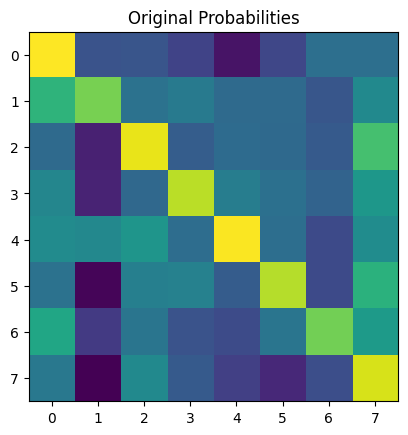

Text(0.5, 1.0, 'New Probabilities')

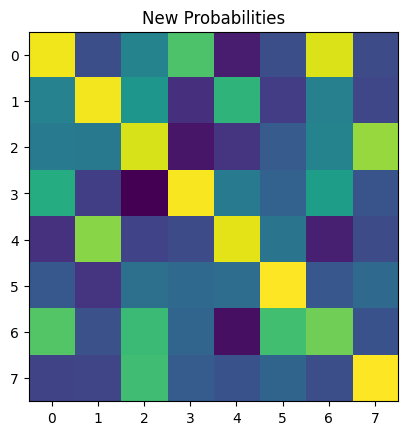

In [ ]:
plt.imshow(original_attn.detach().numpy())
plt.title('Original Probabilities')
plt.show()
plt.imshow(new_attn.detach().numpy())
plt.title('New Probabilities')